In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

In [234]:
sns.set_theme()

Remarks
- No date of transaction (wtf)

Hypotheses
- Price of sell is negociated at -10% max

# Load data

In [2]:
prices = pd.read_csv('Prix IDF.xlsx - Prix.csv')
rentals = pd.read_csv('Prix IDF.xlsx - Loyer.csv')

In [202]:
prices.shape

(44679, 6)

In [3]:
prices.head()

Code Postal  Ville Pièces  Chambres Superficie  Prix de vente
0        75001  PARIS      3       2.0         93      1680000.0
1        75001  PARIS      3       2.0       87,4      1295000.0
2        75001  PARIS      5       4.0     115,19      1905000.0
3        75001  PARIS      4       4.0       93,5      1177000.0
4        75001  PARIS      2       1.0         54       870000.0

In [203]:
rentals.shape

(16014, 6)

In [4]:
rentals.head()

Unnamed: 0  Code Postal  Ville  Pièces  Chambres Superficie  Loyer
0           0        75001  PARIS       3       1.0         71   2150
1           1        75001  PARIS       2       1.0         35   1600
2           2        75001  PARIS       2       1.0         50   2515
3           3        75001  PARIS       1       NaN         35   1380
4           4        75001  PARIS       2       1.0         42   1700

# Clean data

In [5]:
# Drop dead column
rentals.drop(['Unnamed: 0'], axis=1, inplace=True)

In [21]:
# Replace commas by points
prices = prices.replace(to_replace=',', value='.', regex=True)
rentals = rentals.replace(to_replace=',', value='.', regex=True)

## Cast

Cast variables into:
- Code Postal: category
- Ville: category
- Pièces: int
- Chambres: int  (TODO when NANs are imputed)
- Superficie: float
- Loyer: int
- Prix de vente: float

### Cast categories

In [7]:
# Cast Code Postal as category
prices['Code Postal'] = prices['Code Postal'].astype('category')
rentals['Code Postal'] = rentals['Code Postal'].astype('category')

# Cast Ville as category
prices['Ville'] = prices['Ville'].astype('category')
rentals['Ville'] = rentals['Ville'].astype('category')

### Cast Pièces (and clean)

In [8]:
# Get outliers
p_out = [val for val in prices['Pièces'] if float(val) != round(float(val))]
r_out = [val for val in rentals['Pièces'] if float(val) != round(float(val))]
print('prices', p_out)
print('rentals', r_out)

prices ['25.44', '54.54', '17.46', '130.44', '63.72', '194.56', '47.89']
rentals []


Prices:
- Few outliers
- Round to closest (as no importance) the outliers to cast as int
- Fun fact: only 1 house sold having 13 rooms. Whereas 20 and 6 were sold having 12 and 14 rooms respectivelly
- Max rooms in a sell: 195

Rentals:
- No outlier
- Max rooms in a rental: 20

In [9]:
# Prices: Cast from object to float
prices['Pièces'] = prices['Pièces'].astype('float32')
# Prices: Round
prices['Pièces'] = prices['Pièces'].apply(round)

In [10]:
# Cast to int32
prices['Pièces'] = prices['Pièces'].astype('int32')
rentals['Pièces'] = rentals['Pièces'].astype('int32')

### Cast Superficie

In [11]:
# a = prices['Superficie'].astype('float32', errors='ignore')
err = []
for v in prices['Superficie']:
    try:
        float(v)
    except:
        err.append(v)

In [12]:
err

['²1', '²1', '²1', '²1', '²1']

In [13]:
# Analyse errors
prices[prices['Superficie'] == '²1']

Code Postal          Ville  Pièces  Chambres Superficie  Prix de vente
34824       93300  Aubervilliers      55       NaN         ²1       210000.0
34825       93300  Aubervilliers      17       NaN         ²1        96000.0
34827       93300  Aubervilliers      64       NaN         ²1       234000.0
34828       93300  Aubervilliers     195       NaN         ²1       738000.0
34829       93300  Aubervilliers      48       NaN         ²1       186000.0

- These are errors definitely, since houses with +17 rooms are incoherent with these prices
- Drop these outliers

In [14]:
# Drop outliers
ma_no_outliers = prices['Superficie'] == '²1'
prices = prices[~ma_no_outliers]

In [15]:
# Cast to float
prices['Superficie'] = prices['Superficie'].astype('float32')
rentals['Superficie'] = rentals['Superficie'].astype('float32')

### Cast Loyer to int32

In [16]:
rentals['Loyer'] = rentals['Loyer'].astype('int32')

### Cast Prix de vente

In [17]:
prices['Prix de vente'] = prices['Prix de vente'].astype('float32')

## Categorize

###  Code Postal (one-hot / better algo)

###  Ville (one-hot / better algo)

## Outliers

- Superficie lower than 8, inspect price coherence
- Same for highest Superficie

- Idem very low prices

## Missing (NaN)

### Prix de vente
- 1 missing
- Drop it
- if time left, impute it

In [26]:
# Prix de vente
ma_out_px = prices['Prix de vente'].isna()
prices[ma_out_px]

Code Postal                  Ville  Pièces  Chambres  Superficie  \
38429       94100  Saint-Maur-des-Fossés       4       3.0        87.0   

       Prix de vente  
38429            NaN

In [28]:
# Drop na
prices = prices[~ma_out_px]

### Chambres
- There might be a close link between Chambres NaNs and Pièces number
- Some advertisements have many rooms, with might be explained by large rooms counting as multiple rooms [https://www.logic-immo.com/vendre/estimer-bien-immobilier/calculer-nombre-pieces-maison-appartement-1-20-40](cf)

#### Study Prices

(0.0, 200.0)

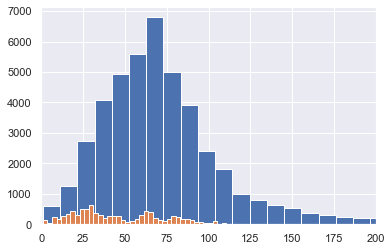

In [236]:
prices['Superficie'].hist(bins=150)
ma_na_chamb = prices['Chambres'].isna()
prices[ma_na_chamb]['Superficie'].hist(bins=150)
plt.xlim([0, 200])

(0.0, 10.0)

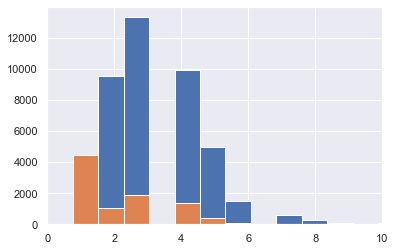

In [238]:
prices['Pièces'].hist(bins=200)
ma_na_pieces = prices['Chambres'].isna()
prices[ma_na_pieces]['Pièces'].hist(bins=200)
plt.xlim([0, 10])

Chambres:
- When missing and 1 Pièces only, it is a studio, and can be replaced by 0
- When there are 2 Pièces, NaN can be replaced by 1.
- For > 2 Pièces, its hard to tell.

#### Study Rentals

(0.0, 8.0)

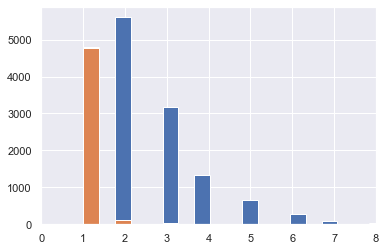

In [250]:
rentals['Pièces'].hist(bins=50)
ma_na_pieces_rent = rentals['Chambres'].isna()
rentals[ma_na_pieces_rent]['Pièces'].hist(bins=50)
plt.xlim([0, 8])

- There is an even clearer pattern, with missing Chambres representing studios
- NAs can be imputed with a 0 or 1 (to think)

In [251]:
# TODO: replace the NAs following above rules


# Further analysis

In [18]:
profile_prices = ProfileReport(prices, title="Prices report")
profile_prices.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Prices report analysis

- Many duplicated rows 21.6%. These are transactions and should not be treated as duplicates. With these variables, it is probable enough to have similar houses sold at the same price
- 'Chambres' is the only variable with missing values
- 'Ville' represents IDF, with Paris at 41.5%. 122 different cities (paris included)
- Code Postal 141 vs Ville 122. There exists multiple Code Postal in Paris (20)



Rentals report analysis

- 'Ville' also IDF, with 121 cities

Prices vs Rentals
- 1 ville / code Postal de moins dans rentals (vs prices) (92230, Gennevilliers)

In [53]:
code_px = prices['Code Postal'].unique()
code_rent = rentals['Code Postal'].unique()
[code for code in code_px if code not in code_rent]

[92230]

In [109]:
plt.heat prices[prices[['Pièces', 'Chambres']].isna()]

Code Postal Ville  Pièces  Chambres  Superficie  Prix de vente
0             NaN   NaN     NaN       NaN         NaN            NaN
1             NaN   NaN     NaN       NaN         NaN            NaN
2             NaN   NaN     NaN       NaN         NaN            NaN
3             NaN   NaN     NaN       NaN         NaN            NaN
4             NaN   NaN     NaN       NaN         NaN            NaN
...           ...   ...     ...       ...         ...            ...
44680         NaN   NaN     NaN       NaN         NaN            NaN
44681         NaN   NaN     NaN       NaN         NaN            NaN
44682         NaN   NaN     NaN       NaN         NaN            NaN
44683         NaN   NaN     NaN       NaN         NaN            NaN
44684         NaN   NaN     NaN       NaN         NaN            NaN

[44679 rows x 6 columns]